This script is designed to help the user decide on k, the number of clusters/Cloud regimes to produce. It will preform clustering for values of k within the range specified by the user editable k_range variable. For each value of k this script will create two correlation matrices, one that shows the correlation between each of the CR histograms, and one that shows the correlations between spatial distribution of the CRs. If an increase in k has produced two CRs that are highly correlated with each other, than this value of k may be too high, and the lower value should be considered as the final value of k. High correlation between CR centers can be considered around 0.8, while a high spatial correlation value may be considered to be around 0.3.


Importing necesary packages and functions

In [1]:
import numpy as np
import xarray as xr
from Functions import emd_means, euclidean_kmeans, plot_hists, plot_rfo, histogram_cor, spacial_cor, open_and_process, kp1_histogram_cor
import logging as lgr
import dask

Defining variables for data and k-means. For the first time running through this leave these how they are, but later on feel free to experiment. For example if you preform this analysis for only 30N to 30S over ocean does the final value of k you decide on change? Is it smaller or larger? 

In [2]:
# Path to data to cluster
data_path = "./ISCCP_toy_data.nc"

# Path to the directory you wish to save plots in if running as a script, if None plots will only be shown and not saved. Enter as String
save_path = None
save_prefix = None  # prefix to put into the name of each plot to distinguish different runs of this script

# Variable name of data to cluster in data_path
# Name of tau dimension for var_name
# Name of height/pressure dimension for var_name
var_name =  'n_pctaudist' 
tau_var_name =  'levtau' 
ht_var_name =  'levpc'
lat_var_name = 'lat'
lon_var_name = 'lon'

# Does this dataset use cloud top height or cloud top pressure? enter "h" for height or "p" for pressure
height_or_pressure = 'p'

# kmeans properties
tol = 10000   # maximum change in inertia values between kmeans iterations to declare convergence. should be higher if using wasserstein distance
max_iter = 1000   # maximum number of k-means iterations to preform for each initiation
init='k-means++'    # initialization technique for kmeans, can be 'k-means++', 'random', or initial clusters to use of shape (k, n_tau_bins * n_pressure_bins)
n_init = 1   # number of initiations of the k-means algorithm. The final result will be the initiation with the lowest calculated inertia
gpu = False  # If the user has an Nvidia GPU, euclidean clustering can br preformed on it for a very significant speed up. CUPY/CUML must be installed in conda environment.

# k sensitivity testing properties
k_range = [3,4] # minimum and maximum values for k to test

# Plot the CR centers and rfo maps? or just the correlation matricies
plot_cr_centers = True
plot_rfo_graphs = True

# Choose whether to use a euclidean or wasserstein distance kmeans algorithm
wasserstein_or_euclidean = "euclidean"

# Minimum and Maximum longitudes and latitudes entered as list, or None for entire range
lat_range = [-90,90]
lon_range = [-180,180]

# Time Range min and max, or None for all time, entered as list of str: Ex. ["2003-03-01", "2004-07-01"] or ['2003','2007']
time_range = None

# Use data only over land or over ocean
# Set to 'L' for land only, 'O' for ocean only, or False for both land and ocean
only_ocean_or_land = False
# Does this dataset have a built in variable for land fraction? if so enter as a string, otherwise cartopy will be used to mask out land or water
land_frac_var_name = None

# Logging level, set to "INFO" for information about what the code is doing, otherwise keep at "WARNING"
logging_level = 'INFO'

Openining data and preprocessing for clustering.

In [3]:
# Setting up logger
lgr.root.setLevel(logging_level)
# Avoid creation of large chunks with dask
dask.config.set({"array.slicing.split_large_chunks": False})
# Automatically setting premade_cloud_regimes to none because this file does not need them. Do not Change.
premade_cloud_regimes = None
# Setting k to an arbitrary number as it wont be used
k=-1
# Concatenating save_path and save prefix
if save_path != None: save_path = save_path + save_prefix

# Opening and preprocessing data
mat, valid_indicies, ds, histograms, weights = open_and_process(data_path, k, tol, max_iter, init, n_init, var_name, tau_var_name, ht_var_name, lat_var_name, lon_var_name, height_or_pressure, wasserstein_or_euclidean, premade_cloud_regimes, lat_range, lon_range, time_range, only_ocean_or_land, land_frac_var_name, cluster = False)


INFO:root: Opening dataset:
INFO:root: Opening finished. Beginning preprocessing:
INFO:root: Reshaping data to shape (n_histograms, n_tau_bins* n_pc_bins):
INFO:root: Reading data into memory:
INFO:root: Finished preprocessing:


Prforming clustering for k in k_range then plotting correlation matricies of CR centers and the CRs spatial distributions. Reme

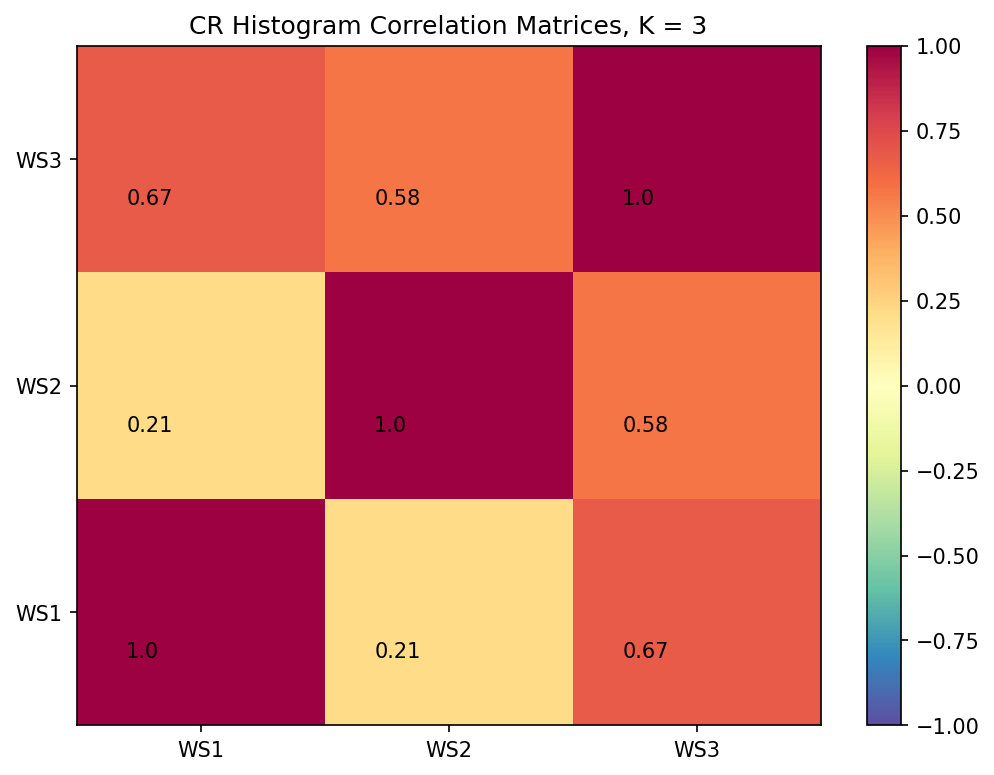

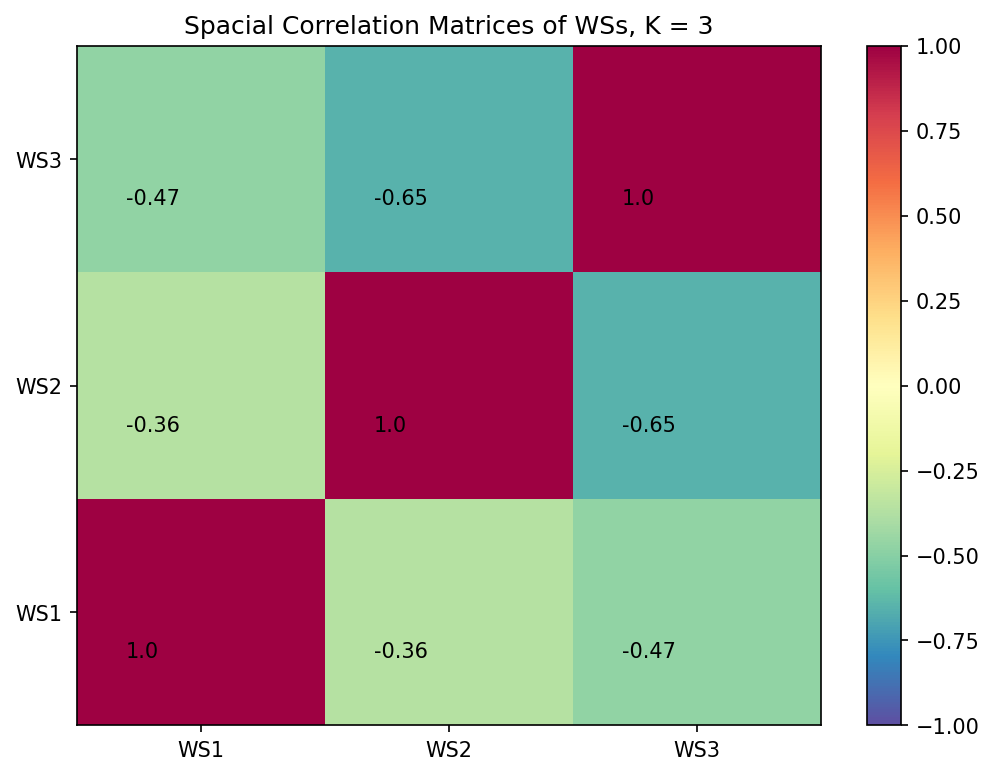

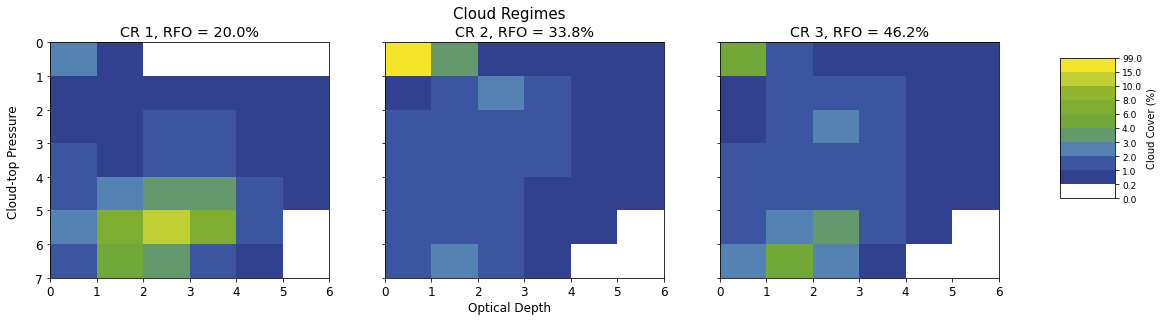

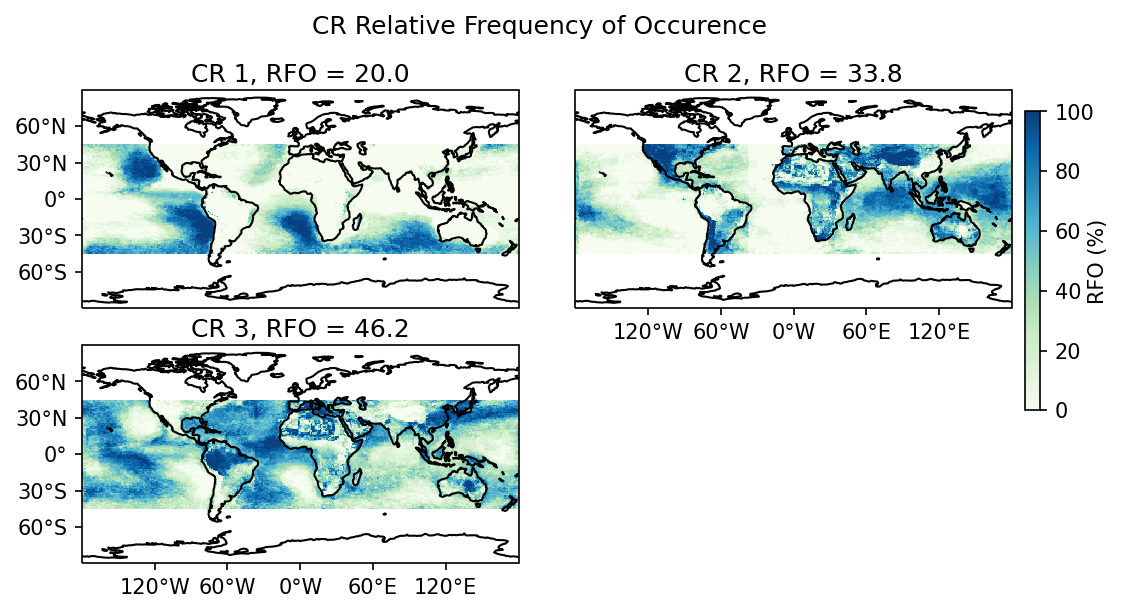

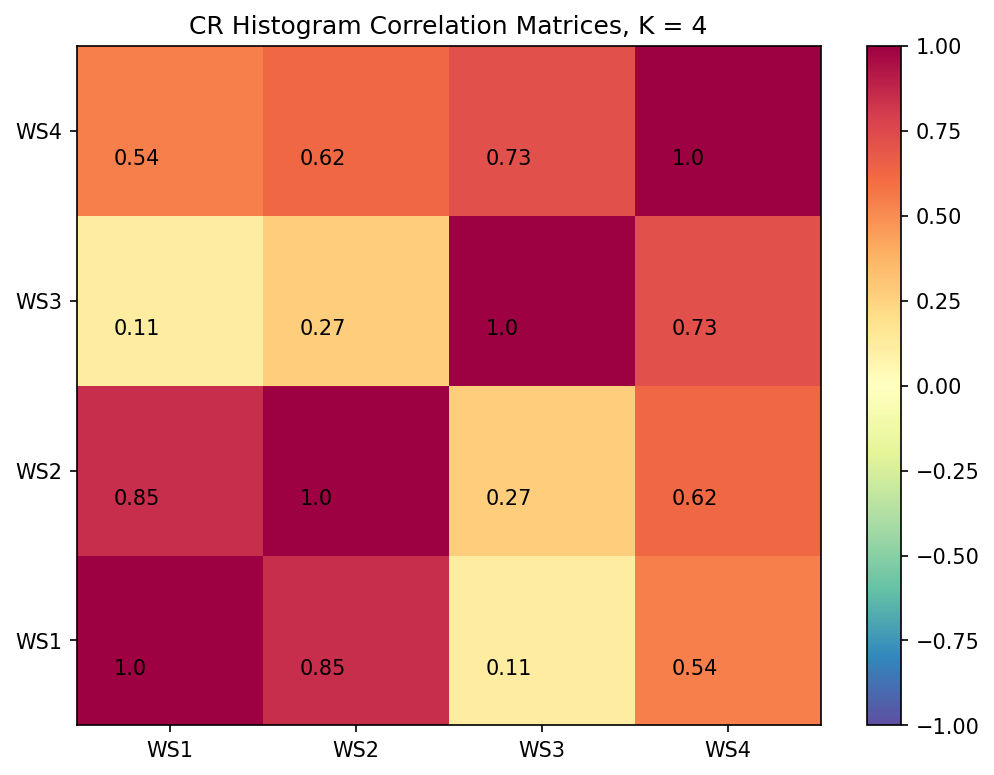

k = 4 failed the histogram correlation test. The maximum alowable correlation is 0.8, but the maximum correlation is 0.85


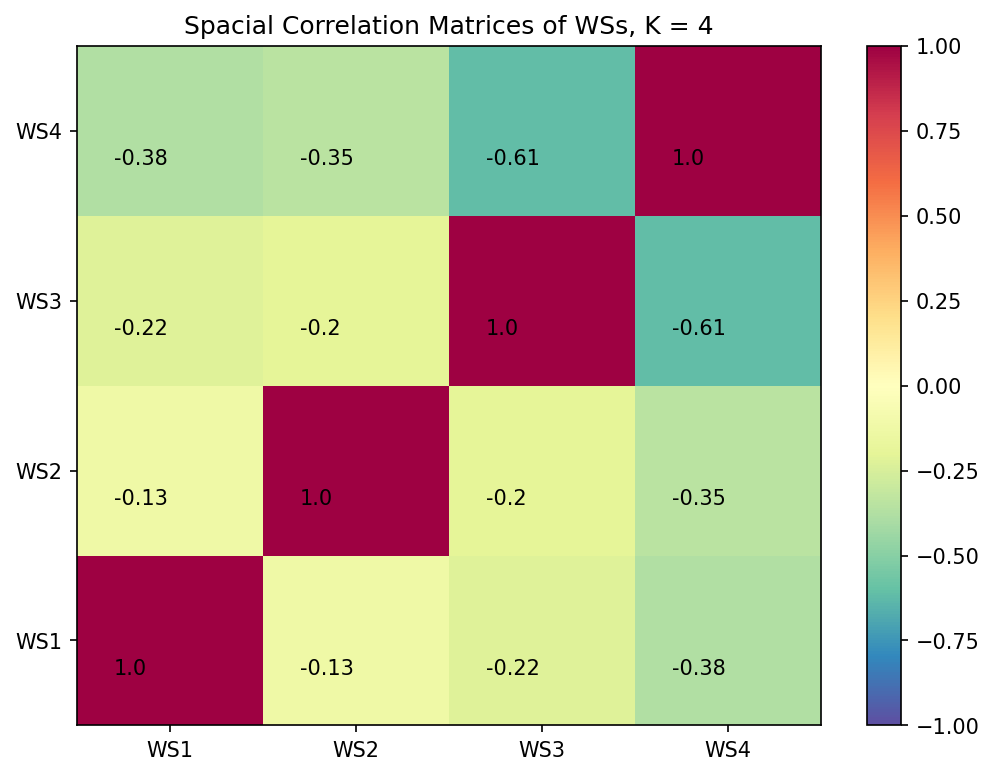

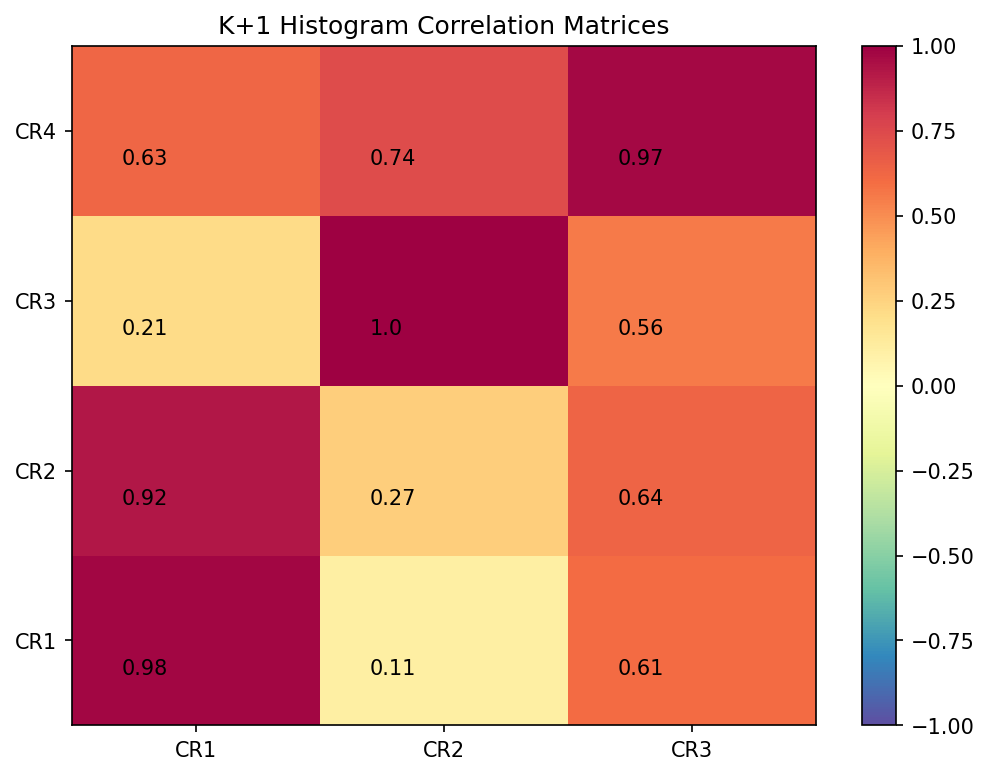

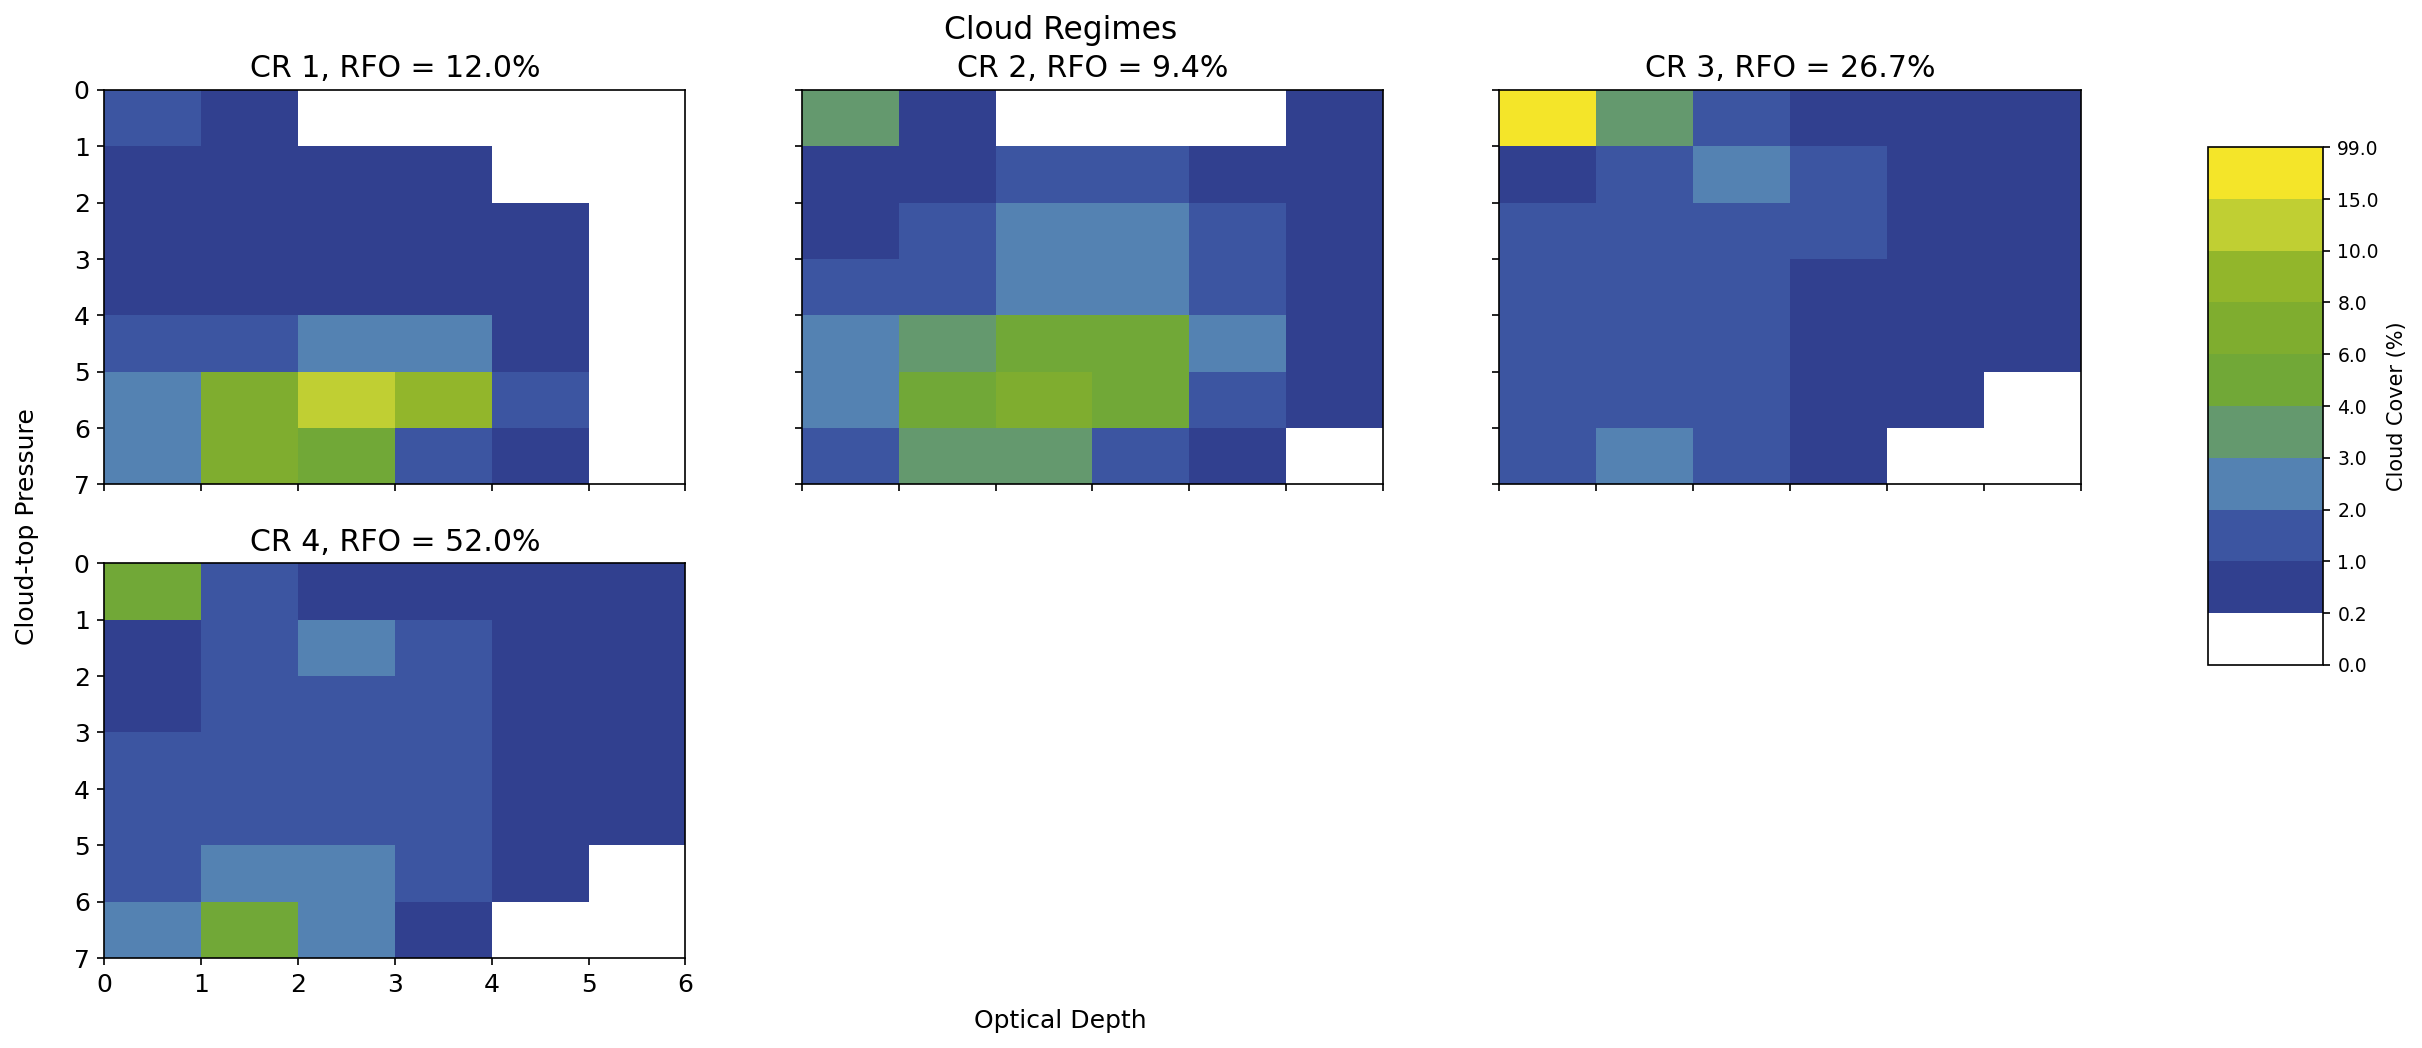

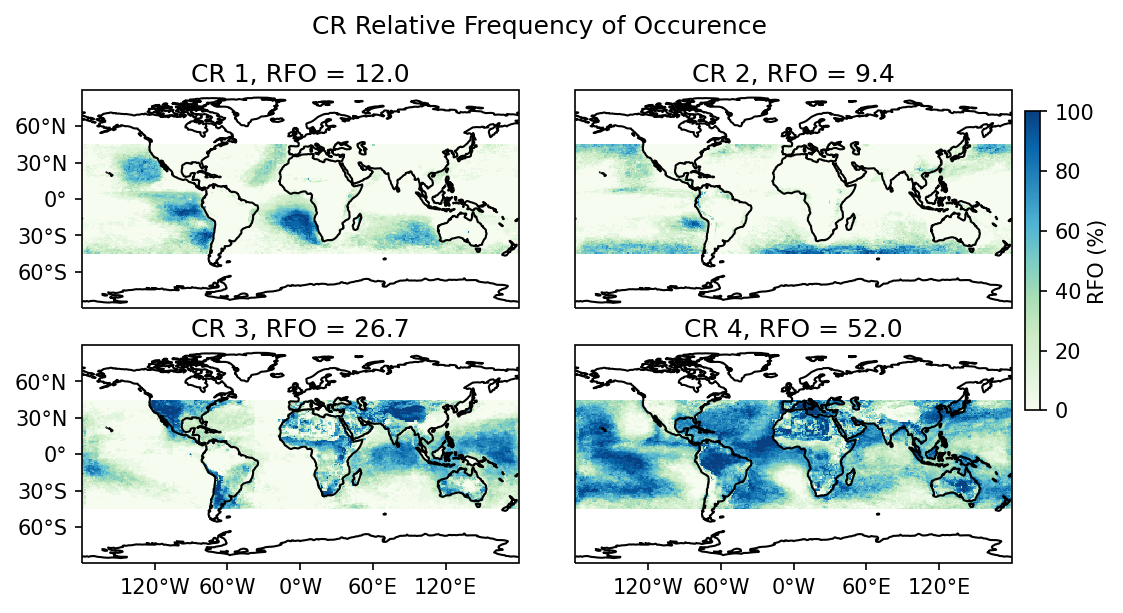

In [4]:
# Preform clustering with specified distance metric, for all values of k in k_range and create diagnostic plots
cl_list = [] # cariable to save cl for various values of k 
ratio_list = []
for i, k in enumerate(np.arange(k_range[0], k_range[1]+1)):
    if wasserstein_or_euclidean == "wasserstein":
        cl, cluster_labels_temp, il, cl_list = emd_means(mat, k=k, tol=tol, init=init, n_init = n_init, hard_stop=max_iter, weights=weights)
    elif wasserstein_or_euclidean == "euclidean":
        cl, cluster_labels_temp = euclidean_kmeans(k, init, n_init, mat, max_iter, tol, gpu)
    else: raise Exception ('Invalid option for wasserstein_or_euclidean. Please enter "wasserstein", "euclidean"')
    cl_list.append(cl)

    # Reshaping cluster_labels_temp to original shape of ds and reinserting NaNs in the original places, so spatial correlations can be calcualated
    cluster_labels = np.full(len(histograms), np.nan, dtype=np.int32)
    cluster_labels[valid_indicies]=cluster_labels_temp
    cluster_labels = xr.DataArray(data=cluster_labels, coords={"spacetime":histograms.spacetime},dims=("spacetime") )
    cluster_labels = cluster_labels.unstack()

    # Plotting correlation matrices
    histogram_cor(cl, save_path)
    spacial_cor(cluster_labels_temp,k, save_path)
    
    if i >0: kp1_histogram_cor(cl_list[i], cl_list[i-1], save_path)

    if plot_cr_centers:
        plot_hists(cluster_labels, k, ds, ht_var_name, tau_var_name, valid_indicies, mat, cluster_labels_temp, height_or_pressure, save_path)

    if plot_rfo_graphs:
        plot_rfo(cluster_labels,k,ds, save_path)